# MCP tous les models avec X_train y_train sur le vecteur ['speed_ref','hour','dir_ref','wind_sector']


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
#import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RANSACRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
from windrose import WindroseAxes


In [2]:
# appel de la fonction eval_plot 
def eval_plot(y_test,y_pred):
    plt.scatter(y_test, y_pred, alpha=0.3, label='Data Points')
    
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',label='Perfect predection')
    reg = LinearRegression().fit(y_test.values.reshape(-1,1), y_pred)
    y_fit = reg.predict(y_test.values.reshape(-1,1))
    plt.plot(y_test, y_fit, 'r-', lw=2, 
         label=f'Regression (Slope={reg.coef_[0]:.2f}, R²={r2_score(y_test, y_pred):.2f})')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [3]:
reference_df = pd.read_csv("Era5_Bordj_Bahri_8ans.csv", parse_dates=["datetime"])
mesure_df = pd.read_csv("BORDJ EL BAHRI00.csv", sep=';',parse_dates=['datetime'])
print(reference_df.columns)
print(mesure_df.columns)
 
reference_df['datetime'] = pd.to_datetime(reference_df['datetime'])
mesure_df['datetime'] = pd.to_datetime(mesure_df['datetime'],format='mixed',dayfirst=True)

# .Divide the wind speed by 10
#mesure_df["VV"] = mesure_df["VV"] / 10

#reference_df.to_csv("reference_df_resultat.csv", index=False)
#mesure_df.to_csv("mesure_df_resultat.csv", index=False)

mesure_df = mesure_df.rename(columns={'VV': 'speed_mesure', 'DD': 'dir_mesure'})
reference_df = reference_df.rename(columns={'wind_speed': 'speed_ref', 'wind_direction': 'dir_ref'})

# Fusion sur datetime
merged = pd.merge(mesure_df, reference_df, on='datetime', how='inner')
 
reference_df = reference_df.merge(
    mesure_df[['datetime', 'speed_mesure']],
    on='datetime',
    how='left'
)

Index(['datetime', 'wind_speed', 'wind_direction'], dtype='object')
Index(['datetime', 'VV', 'DD'], dtype='object')


In [4]:
#Exploitation des Donnes 
merged.info()
merged.describe()
merged.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16327 entries, 0 to 16326
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      16327 non-null  datetime64[ns]
 1   speed_mesure  16327 non-null  float64       
 2   dir_mesure    16327 non-null  float64       
 3   speed_ref     16327 non-null  float64       
 4   dir_ref       16327 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 637.9 KB


datetime        0
speed_mesure    0
dir_mesure      0
speed_ref       0
dir_ref         0
dtype: int64

In [ ]:
merged.describe()

In [ ]:
merged.head()

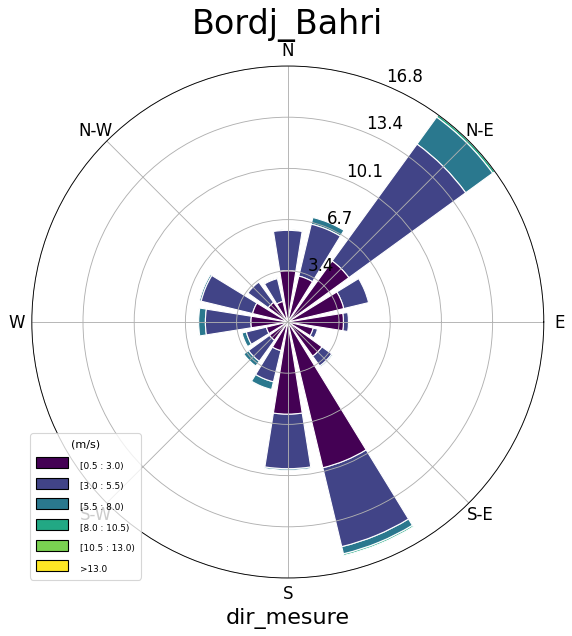

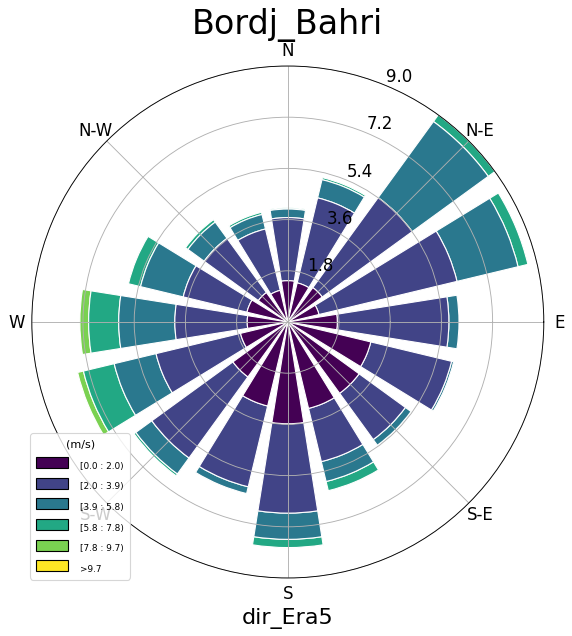

In [7]:
ax = WindroseAxes.from_ax()
out = ax.bar(merged['dir_mesure'], merged['speed_mesure'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="(m/s)",fontsize=14)
ax.tick_params(axis="both", which= "major", labelsize=15)
plt.xlabel("dir_mesure",fontsize=20)
ax.set_title('Bordj_Bahri',fontsize=30)
ax = WindroseAxes.from_ax()
ax.bar(merged['dir_ref'], merged['speed_ref'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="(m/s)",fontsize=14)
plt.xlabel("dir_Era5",fontsize=20)
ax.set_title('Bordj_Bahri',fontsize=30)
ax.tick_params(axis="both", which= "major", labelsize=15)

In [8]:
for column in merged.columns:
    fig = px.box(merged, y=column, title=f'Box Plot for {column}')
    
    # Update layout to center the title and make it bold
    fig.update_layout(
        title=dict(text=f'<b>Box Plot for {column}</b>', x=0.5),
        boxmode='group'  
    )
    
    fig.show()

In [9]:
def classify_wind_dir(degree):
    if (degree >= 337.5) or (degree < 22.5):
        return 1  # North
    elif degree < 67.5:
        return 2  # NE
    elif degree < 112.5:
        return 3  # E
    elif degree < 157.5:
        return 4  # SE
    elif degree < 202.5:
        return 5  # S
    elif degree < 247.5:
        return 6  # SW
    elif degree < 292.5:
        return 7  # W
    else:
        return 8  # NW


def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    else:
        return 4 

In [10]:
#feature engeenering 
merged['hour'] = merged['datetime'].dt.hour
merged['month'] = merged['datetime'].dt.month
merged['day_of_week'] = merged['datetime'].dt.dayofweek
merged['day_of_year'] = merged['datetime'].dt.dayofyear
merged['dir_mesure_rad'] = np.deg2rad(merged['dir_mesure'])
merged['dir_mesure_sin'] = np.sin(merged['dir_mesure_rad'])
merged['dir_mesure_cos'] = np.cos(merged['dir_mesure_rad'])
merged['season'] = merged['month'].apply(get_season)
merged['wind_sector'] = merged['dir_ref'].apply(classify_wind_dir)



reference_df['month'] = reference_df['datetime'].dt.month
reference_df['season'] = reference_df['month'].apply(get_season)
reference_df['hour'] = reference_df['datetime'].dt.hour
reference_df['wind_sector'] = reference_df['dir_ref'].apply(classify_wind_dir)


# how to split the data ? 


1 st aproach
 Last 6 Months for Testing
If you want finer evaluation:

In [11]:
'''
split_date = '2012-07-01'

train = merged[merged['datetime'] < split_date]
test = merged[merged['datetime'] >= split_date]
'''


"\nsplit_date = '2012-07-01'\n\ntrain = merged[merged['datetime'] < split_date]\ntest = merged[merged['datetime'] >= split_date]\n"

Option 1: Split by Year (Best Practice)
Train on all of 2011, test on all of 2012.

In [12]:
'''
train = merged[merged['datetime'] < '2012-01-01']
test = merged[merged['datetime'] >= '2012-01-01']

X_train = train[['datetime', 'speed_ref', 'dir_ref', 'hour', 'wind_sector']]
y_train = train['speed_mesure']

X_test = test[['datetime', 'speed_ref', 'dir_ref', 'hour', 'wind_sector']]
y_test = test['speed_mesure']
'''

"\ntrain = merged[merged['datetime'] < '2012-01-01']\ntest = merged[merged['datetime'] >= '2012-01-01']\n\nX_train = train[['datetime', 'speed_ref', 'dir_ref', 'hour', 'wind_sector']]\ny_train = train['speed_mesure']\n\nX_test = test[['datetime', 'speed_ref', 'dir_ref', 'hour', 'wind_sector']]\ny_test = test['speed_mesure']\n"

Normal aproach 
Not respect season boundaries.

Give an incomplete view of temporal patterns in either set.

In [13]:

X = merged[['speed_ref','dir_ref','hour','wind_sector']] 
y = merged['speed_mesure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 


Text(0.5, 1.0, ' stellar correlation matrix')

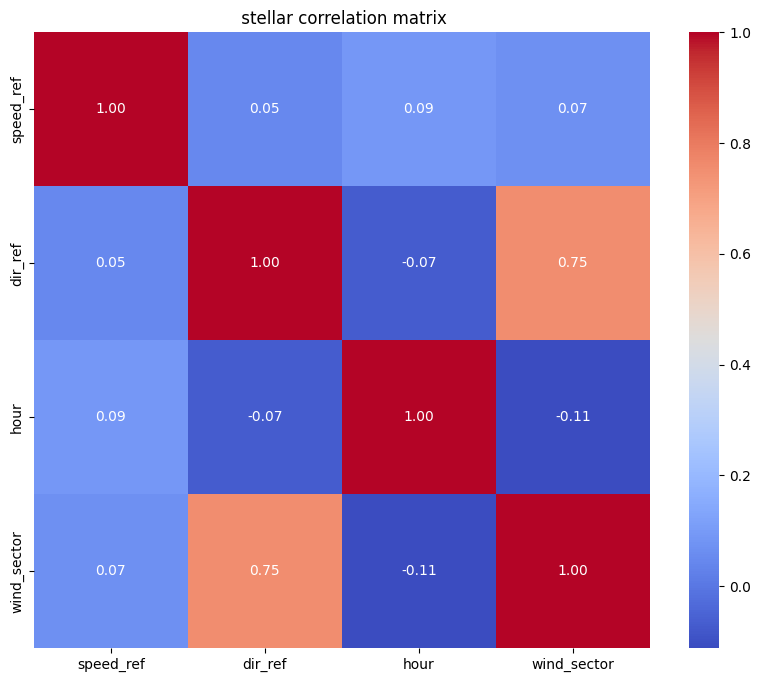

In [14]:
corr_matt=X.corr(method="pearson")
plt.figure(figsize=(10,8))
sns.heatmap(corr_matt,annot=True,fmt="0.2f",cmap="coolwarm",square=True)
plt.title(" stellar correlation matrix")

In [16]:
print(y_train.shape)
print(y_test.shape)

(13061,)
(3266,)


# les models de Regression

## Linear Regression

In [17]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
ylin = model_lin.predict(X_test)

### Evaluation 

In [18]:
mae = mean_absolute_error(y_test, ylin)
rmse = np.sqrt(mean_squared_error(y_test, ylin))
r2 = r2_score(y_test, ylin)
linre_r2=r2
print(f"\n Model trained on 2011")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


 Model trained on 2011
MAE:  0.836
RMSE: 1.075
R²:   0.448


##  Random Forest Regression

### Grid Search to find best paramters 

In [19]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

modelrf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=modelrf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all cores
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
ypredbest = best_model.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
34 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### Evaluation

In [20]:
mae = mean_absolute_error(y_test, ypredbest)
rmse = np.sqrt(mean_squared_error(y_test, ypredbest))
r2 = r2_score(y_test, ypredbest)
linre_r2=r2
print(f"\n Model trained on 2011")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


 Model trained on 2011
MAE:  0.781
RMSE: 1.025
R²:   0.499


## XGB Regression

In [21]:
modelXGB = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1)
modelXGB.fit(X_train, y_train)
y_predXGB = modelXGB.predict(X_test)


### Evaluation

In [22]:
mae = mean_absolute_error(y_test, y_predXGB)
rmse = np.sqrt(mean_squared_error(y_test, y_predXGB))
r2 = r2_score(y_test, y_predXGB)
linre_r2=r2
print(f"\n Model trained on 2011")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


 Model trained on 2011
MAE:  0.798
RMSE: 1.056
R²:   0.468


## Poly Regression Avec degree = 2 

In [23]:
modelpoly2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
modelpoly2.fit(X_train, y_train)
y_predpoly2 = modelpoly2.predict(X_test)

### Evaluation

In [24]:
mae = mean_absolute_error(y_test, y_predpoly2)
rmse = np.sqrt(mean_squared_error(y_test, y_predpoly2))
r2 = r2_score(y_test, y_predpoly2)

print(f"\n✅ Polynomial Regression (degree=2) Evaluation on Test Set:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


✅ Polynomial Regression (degree=2) Evaluation on Test Set:
MAE:  0.799
RMSE: 1.038
R²:   0.486


## Poly Regression Avec degree = 3 

In [25]:
modelpoly3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
modelpoly3.fit(X_train, y_train)
y_predpoly3 = modelpoly3.predict(X_test)

### Evaluation

In [26]:
mae = mean_absolute_error(y_test, y_predpoly3)
rmse = np.sqrt(mean_squared_error(y_test, y_predpoly3))
r2 = r2_score(y_test, y_predpoly3)

print(f"\n✅ Polynomial Regression (degree=3) Evaluation on Test Set:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


✅ Polynomial Regression (degree=3) Evaluation on Test Set:
MAE:  0.798
RMSE: 1.037
R²:   0.487


## Ransac Regression

In [27]:
modelRANSAC = RANSACRegressor(estimator=LinearRegression(), 
                        min_samples=0.8, 
                        residual_threshold=2.0, 
                        random_state=0)
modelRANSAC.fit(X_train, y_train)
Y_predRANSAC = modelRANSAC.predict(X_test)

### Evaluation

In [28]:
mae = mean_absolute_error(y_test, Y_predRANSAC)
rmse = np.sqrt(mean_squared_error(y_test, Y_predRANSAC))
r2 = r2_score(y_test, Y_predRANSAC)

print(f"\n RANSACRegressor Evaluation on Test Set:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


 RANSACRegressor Evaluation on Test Set:
MAE:  0.831
RMSE: 1.071
R²:   0.453


## Evaluation Global de tous les models

In [29]:

print(f"r2 linear : {r2_score(y_test, ylin)} /rmse :{np.sqrt(mean_squared_error(y_test, ylin))} /mae : {mean_absolute_error(y_test, ylin)}")
print(f"r2 ransac : {r2_score(y_test, Y_predRANSAC)} /rmse :{np.sqrt(mean_squared_error(y_test, Y_predRANSAC))} /mae : {mean_absolute_error(y_test, Y_predRANSAC)}")
print(f"r2 poly2 : {r2_score(y_test, y_predpoly2)} /rmse :{np.sqrt(mean_squared_error(y_test, y_predpoly2))} /mae : {mean_absolute_error(y_test, y_predpoly2)}")
print(f"r2 poly3 : {r2_score(y_test, y_predpoly3)} /rmse :{np.sqrt(mean_squared_error(y_test, y_predpoly3))}/mae : {mean_absolute_error(y_test, y_predpoly3)}")

print(f"r2 xgb : {r2_score(y_test, y_predXGB)} /rmse :{np.sqrt(mean_squared_error(y_test, y_predXGB))} /mae : {mean_absolute_error(y_test, y_predXGB)}")
print(f"r2 forest : {r2_score(y_test, ypredbest)}/ rmse :{np.sqrt(mean_squared_error(y_test, ypredbest))}/mae : {mean_absolute_error(y_test, ypredbest)}")

r2 linear : 0.4481730671316797 /rmse :1.0752574997755135 /mae : 0.8363618321338557
r2 ransac : 0.45260579239461973 /rmse :1.0709301181414974 /mae : 0.8308788778092746
r2 poly2 : 0.4861757987924715 /rmse :1.0375721633044934 /mae : 0.7989560401652349
r2 poly3 : 0.48708182870081496 /rmse :1.0366569804615617/mae : 0.7982201673126619
r2 xgb : 0.46774186252595507 /rmse :1.0560201103093998 /mae : 0.7982556614858273
r2 forest : 0.49861305898816854/ rmse :1.0249378769354256/mae : 0.7810208593219367


## predection on one month (decmber 2012)

In [30]:
# Filter for December 2012
desmbr_2012 = merged[(merged['datetime'] >= '2012-12-01') & (merged['datetime'] <= '2012-12-31')].copy()
X_desmbr_2012 = desmbr_2012[['speed_ref','dir_ref','hour','wind_sector']]
desmbr_2012['predicted_lin'] =  model_lin.predict(X_desmbr_2012) #modele lineaire
desmbr_2012['predicted_rand'] =  best_model.predict(X_desmbr_2012)# foreste 
desmbr_2012['predicted_poly2'] =  modelpoly2.predict(X_desmbr_2012)# polynom 2 
desmbr_2012['predicted_poly3'] =  modelpoly3.predict(X_desmbr_2012)# polynom 3
desmbr_2012['predicted_Ransac'] =  modelRANSAC.predict(X_desmbr_2012)# Ransac 
desmbr_2012['predicted_XGB'] =  modelXGB.predict(X_desmbr_2012)# XGB

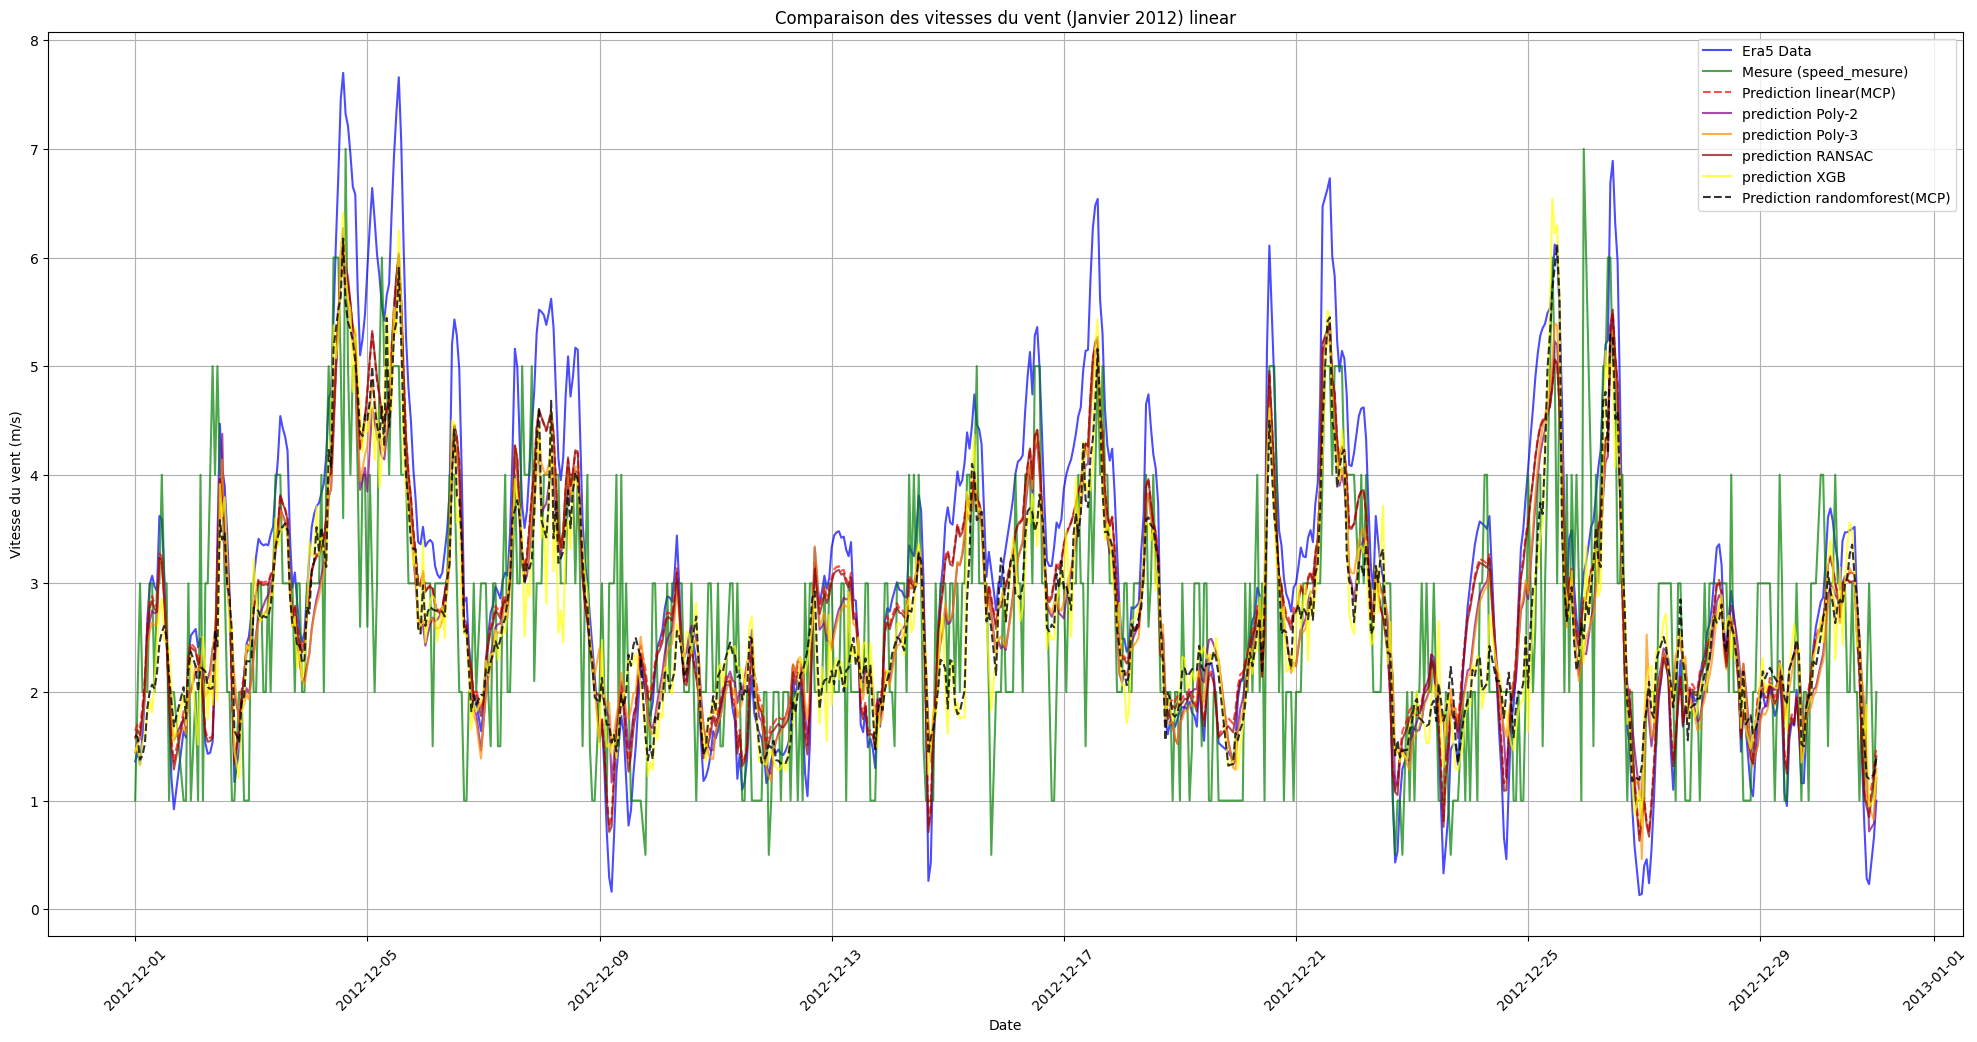

In [31]:
plt.figure(figsize=(20, 10))

# Plot the data

plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["speed_ref"], 
    label="Era5 Data", 
    alpha=0.7,
    color='blue'
)


plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["speed_mesure"], 
    label="Mesure (speed_mesure)", 
    alpha=0.7,
    color='green'
)

plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_lin"],  # Replace with your prediction data (ensure same length as desmbr_2012)
    label="Prediction linear(MCP)", 
    alpha=0.7,
    color='red',
    linestyle='--'
)

plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_poly2"], 
    label="prediction Poly-2", 
    alpha=0.7,
    color='purple'
)

plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_poly3"], 
    label="prediction Poly-3", 
    alpha=0.7,
    color='darkorange'
)
plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_Ransac"], 
    label="prediction RANSAC", 
    alpha=0.7,
    color='darkred'
)

plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_XGB"], 
    label="prediction XGB", 
    alpha=0.7,
    color='yellow'
)


plt.plot(
    desmbr_2012["datetime"], 
    desmbr_2012["predicted_rand"],  # Replace with your prediction data (ensure same length as desmbr_2012)
    label="Prediction randomforest(MCP)", 
    alpha=0.8,
    color= 'black',
    linestyle='--'
)

# Customize the plot
plt.title("Comparaison des vitesses du vent (Janvier 2012) linear")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

## prediction on one week last week of 2012

In [32]:
jan_8day = merged[(merged['datetime'] >= '2012-12-21') & (merged['datetime'] <= '2012-12-29')].copy()
X_jan_8day = jan_8day[['speed_ref','dir_ref','hour','wind_sector']]
jan_8day['predicted_lin'] =  model_lin.predict(X_jan_8day) #modele lineaire
jan_8day['predicted_rand'] =  best_model.predict(X_jan_8day)# foreste 
jan_8day['predicted_poly2'] =  modelpoly2.predict(X_jan_8day)# polynom 2 
jan_8day['predicted_poly3'] =  modelpoly3.predict(X_jan_8day)# polynom 3
jan_8day['predicted_Ransac'] =  modelRANSAC.predict(X_jan_8day)# Ransac 
jan_8day['predicted_XGB'] =  modelXGB.predict(X_jan_8day)# XGB
plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

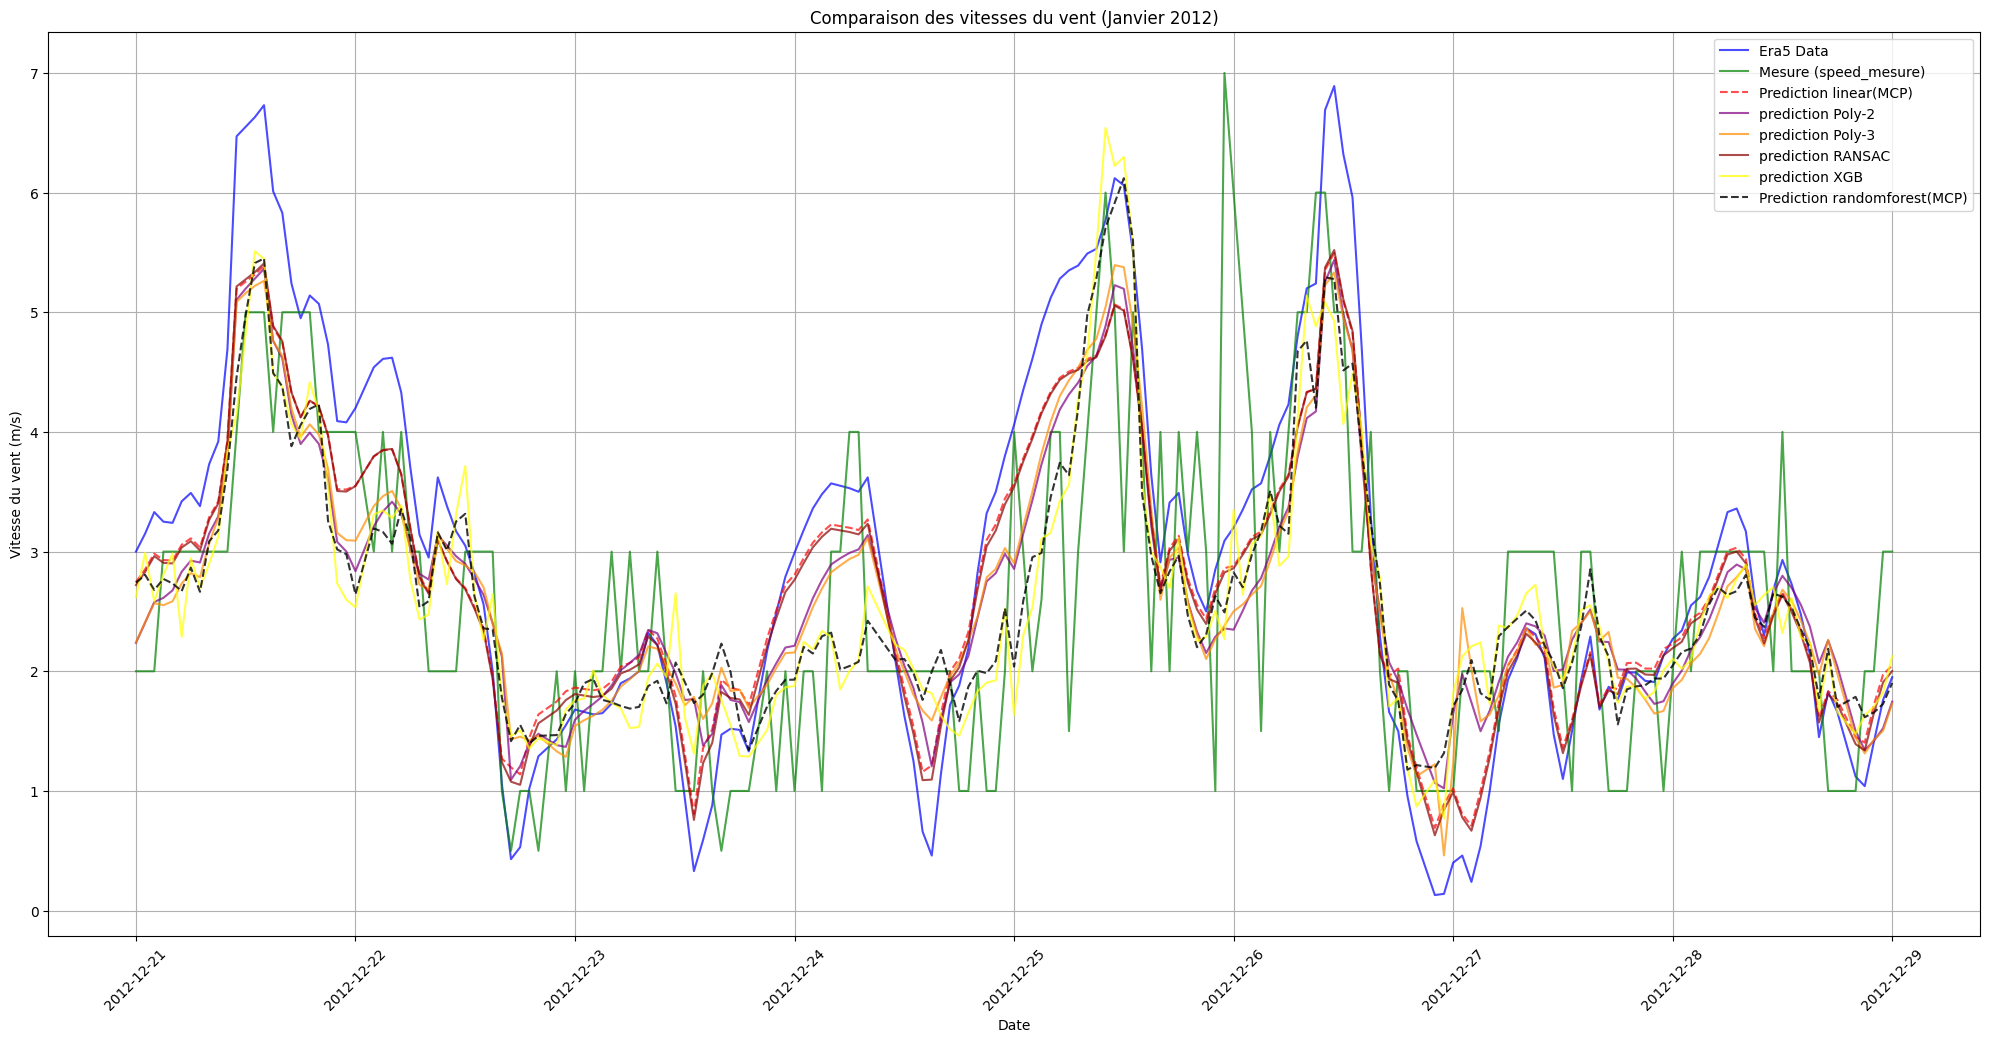

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(
    jan_8day["datetime"], 
    jan_8day["speed_ref"], 
    label="Era5 Data", 
    alpha=0.7,
    color='blue'
)


plt.plot(
    jan_8day["datetime"], 
    jan_8day["speed_mesure"], 
    label="Mesure (speed_mesure)", 
    alpha=0.7,
    color='green'
)

plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_lin"],  # Replace with your prediction data (ensure same length as jan_8day)
    label="Prediction linear(MCP)", 
    alpha=0.7,
    color='red',
    linestyle='--'
)

plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_poly2"], 
    label="prediction Poly-2", 
    alpha=0.7,
    color='purple'
)

plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_poly3"], 
    label="prediction Poly-3", 
    alpha=0.7,
    color='darkorange'
)
plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_Ransac"], 
    label="prediction RANSAC", 
    alpha=0.7,
    color='darkred'
)

plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_XGB"], 
    label="prediction XGB", 
    alpha=0.7,
    color='yellow'
)


plt.plot(
    jan_8day["datetime"], 
    jan_8day["predicted_rand"],  # Replace with your prediction data (ensure same length as jan_8day)
    label="Prediction randomforest(MCP)", 
    alpha=0.8,
    color= 'black',
    linestyle='--'
)

# Customize the plot
plt.title("Comparaison des vitesses du vent (Janvier 2012)")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

## prediction on 8 years including the training data 

In [34]:
 
X_jan_8_years = reference_df[['speed_ref','dir_ref','hour','wind_sector']]
reference_df['predicted_lin']  =  model_lin.predict(X_jan_8_years) #modele lineaire
reference_df['predicted_rand']=  best_model.predict(X_jan_8_years)# foreste 
reference_df['predicted_poly2'] =  modelpoly2.predict(X_jan_8_years)# polynom 2 
reference_df['predicted_poly3'] =  modelpoly3.predict(X_jan_8_years)# polynom 3
reference_df['predicted_Ransac'] =  modelRANSAC.predict(X_jan_8_years)# Ransac 
reference_df['predicted_XGB'] =  modelXGB.predict(X_jan_8_years)# XGB



final_predection_8years = pd.DataFrame({
    'datetime':reference_df['datetime'],
    'speed_ref': reference_df['speed_ref'] ,
    'speed_mesure': reference_df['speed_mesure'] ,
    'predict_linreg': reference_df['predicted_lin'],
    'predict_poly2': reference_df['predicted_poly2'],
    'predict_poly3': reference_df['predicted_poly3'] ,
    'predict_RANSAC': reference_df['predicted_Ransac'] ,
    'predict_XGB': reference_df['predicted_XGB'] ,
    'predict_RandomForest': reference_df['predicted_rand'] ,
})

final_predection_8years.to_csv("mcp_predection_bordj_el_bahri_8_years.csv", index=False)

## weibull distrebution

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:7037: RuntimeWarning:

invalid value encountered in multiply



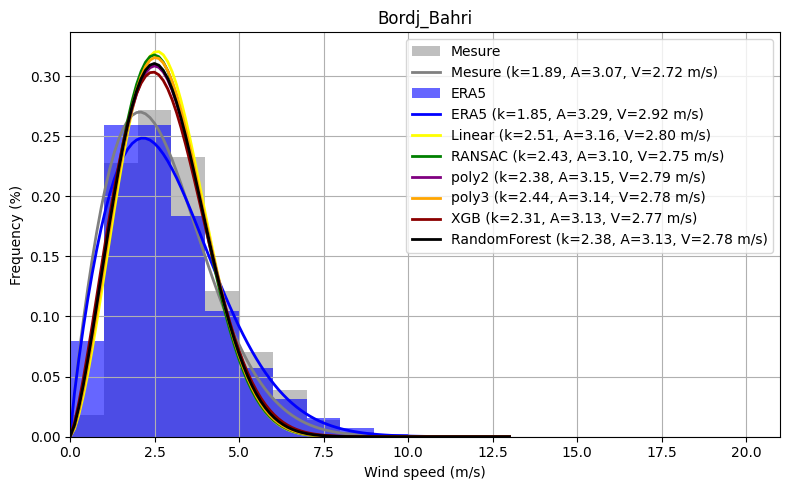

▶ Vitesse moyenne ERA5 : 2.92 m/s
▶ Vitesse moyenne Mesure : 2.72 m/s
▶ Vitesse moyenne MCP Linear : 2.80 m/s
▶ Vitesse moyenne MCP RANSAC : 2.75 m/s
▶ Vitesse moyenne MCP poly2 : 2.79 m/s
▶ Vitesse moyenne MCP poly3 : 2.78 m/s
▶ Vitesse moyenne MCP xgb : 2.77 m/s
▶ Vitesse moyenne MCP random forest : 2.78 m/s


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from scipy.special import gamma

# === 1. Charger les données
df = pd.read_csv('mcp_predection_bordj_el_bahri_8_years.csv',sep=',',parse_dates=['datetime'])  # 'speed_ref', 'speed_mcp'

# === 2. Extraire les colonnes
reel = df['speed_ref'].dropna()
#pred_lin = df['speed_mcp'].dropna()
mesure = df['speed_mesure'].dropna()

# === 3. Ajustement Weibull
c_reel, _, scale_reel = weibull_min.fit(reel, floc=0)
c_mesure, _, scale_mesure = weibull_min.fit(mesure, floc=0)
c_pred_lin, _, scale_pred_lin = weibull_min.fit(df['predict_linreg'], floc=0)
c_pred_poly2, _, scale_pred_poly2 = weibull_min.fit(df['predict_poly2'], floc=0)
c_pred_poly3, _, scale_pred_poly3 = weibull_min.fit(df['predict_poly3'], floc=0)
c_pred_Ransac, _, scale_pred_Ransac = weibull_min.fit(df['predict_RANSAC'], floc=0)
c_pred_XGB, _, scale_pred_XGB = weibull_min.fit(df['predict_XGB'], floc=0)
c_pred_rand, _, scale_pred_rand= weibull_min.fit(df['predict_RandomForest'], floc=0)


# === 4. Tracé des differentes distribution 
x = np.linspace(0, max(reel.max(), mesure.max(), df['predict_linreg'].max(), df['predict_poly2'].max(),df['predict_poly3'].max(),df['predict_RANSAC'].max(),df['predict_XGB'].max(),df['predict_RandomForest'].max()), 100)

plt.figure(figsize=(8, 5))

# Crée les classes : 0-1, 1-2, ..., 19-20, puis [20, +inf]
bins = np.append(np.arange(0, 20, 1), [20, np.inf])

# Histogrammes + courbes Weibull
plt.hist(mesure, bins=bins, density=True, alpha=0.5, color='gray', label='Mesure')
plt.plot(x, weibull_min.pdf(x, c_mesure, 0, scale_mesure), 'gray', lw=2,
         label=f'Mesure (k={c_mesure:.2f}, A={scale_mesure:.2f}, V={scale_mesure * gamma(1 + 1 / c_mesure):.2f} m/s)')
############################################
plt.hist(reel, bins=bins, density=True, alpha=0.6, color='blue', label='ERA5')
plt.plot(x, weibull_min.pdf(x, c_reel, 0, scale_reel), 'b-', lw=2,
         label=f'ERA5 (k={c_reel:.2f}, A={scale_reel:.2f}, V={scale_reel * gamma(1 + 1 / c_reel):.2f} m/s)')
############################################
plt.plot(x, weibull_min.pdf(x, c_pred_lin, 0, scale_pred_lin), 'yellow', lw=2,
         label=f'Linear (k={c_pred_lin:.2f}, A={scale_pred_lin:.2f}, V={scale_pred_lin * gamma(1 + 1 / c_pred_lin):.2f} m/s)')
############################################
#plt.hist(pred_RANSA, bins=bins, density=True, alpha=0.5, color='darkred', label='MCP RANSAC')
plt.plot(x, weibull_min.pdf(x, c_pred_Ransac, 0, scale_pred_Ransac), 'green', lw=2,
         label=f'RANSAC (k={c_pred_Ransac:.2f}, A={scale_pred_Ransac:.2f}, V={scale_pred_Ransac * gamma(1 + 1 / c_pred_Ransac):.2f} m/s)')
##########################################
#plt.hist(pred_RANSA, bins=bins, density=True, alpha=0.5, color='darkred', label='MCP RANSAC')
plt.plot(x, weibull_min.pdf(x, c_pred_poly2, 0, scale_pred_poly2), 'purple', lw=2,
         label=f'poly2 (k={c_pred_poly2:.2f}, A={scale_pred_poly2:.2f}, V={scale_pred_poly2 * gamma(1 + 1 / c_pred_poly2):.2f} m/s)')
#####################################################################
plt.plot(x, weibull_min.pdf(x, c_pred_poly3, 0, scale_pred_poly3), 'orange', lw=2,
         label=f'poly3 (k={c_pred_poly3:.2f}, A={scale_pred_poly3:.2f}, V={scale_pred_poly3 * gamma(1 + 1 / c_pred_poly3):.2f} m/s)')
#####################################################################
plt.plot(x, weibull_min.pdf(x, c_pred_XGB, 0, scale_pred_XGB), 'darkred', lw=2,
         label=f'XGB (k={c_pred_XGB:.2f}, A={scale_pred_XGB:.2f}, V={scale_pred_XGB * gamma(1 + 1 / c_pred_XGB):.2f} m/s)')
#####################################################################
plt.plot(x, weibull_min.pdf(x, c_pred_rand, 0, scale_pred_rand), 'black', lw=2,
         label=f'RandomForest (k={c_pred_rand:.2f}, A={scale_pred_rand:.2f}, V={scale_pred_rand * gamma(1 + 1 / c_pred_rand):.2f} m/s)')


# === 5. Mise en forme
plt.xlabel('Wind speed (m/s)')
plt.xlim(0, 21)  # Limite l'axe X de 0 à 21 m/s
plt.ylabel('Frequency (%)')
plt.title('Bordj_Bahri')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('weibull_comparaison_bordj_el_bahri.png', dpi=300, bbox_inches='tight')  # haute qualité
plt.show()

# === 6. Moyennes Weibull
print(f"▶ Vitesse moyenne ERA5 : {scale_reel * gamma(1 + 1 / c_reel):.2f} m/s")
print(f"▶ Vitesse moyenne Mesure : {scale_mesure * gamma(1 + 1 / c_mesure):.2f} m/s")
print(f"▶ Vitesse moyenne MCP Linear : {scale_pred_lin * gamma(1 + 1 / c_pred_lin):.2f} m/s")
print(f"▶ Vitesse moyenne MCP RANSAC : {scale_pred_Ransac * gamma(1 + 1 / c_pred_Ransac):.2f} m/s")
print(f"▶ Vitesse moyenne MCP poly2 : {scale_pred_poly2 * gamma(1 + 1 / c_pred_poly2):.2f} m/s")
print(f"▶ Vitesse moyenne MCP poly3 : {scale_pred_poly3 * gamma(1 + 1 / c_pred_poly3):.2f} m/s")
print(f"▶ Vitesse moyenne MCP xgb : {scale_pred_XGB * gamma(1 + 1 / c_pred_XGB):.2f} m/s")
print(f"▶ Vitesse moyenne MCP random forest : {scale_pred_rand * gamma(1 + 1 / c_pred_rand):.2f} m/s")

## regression line

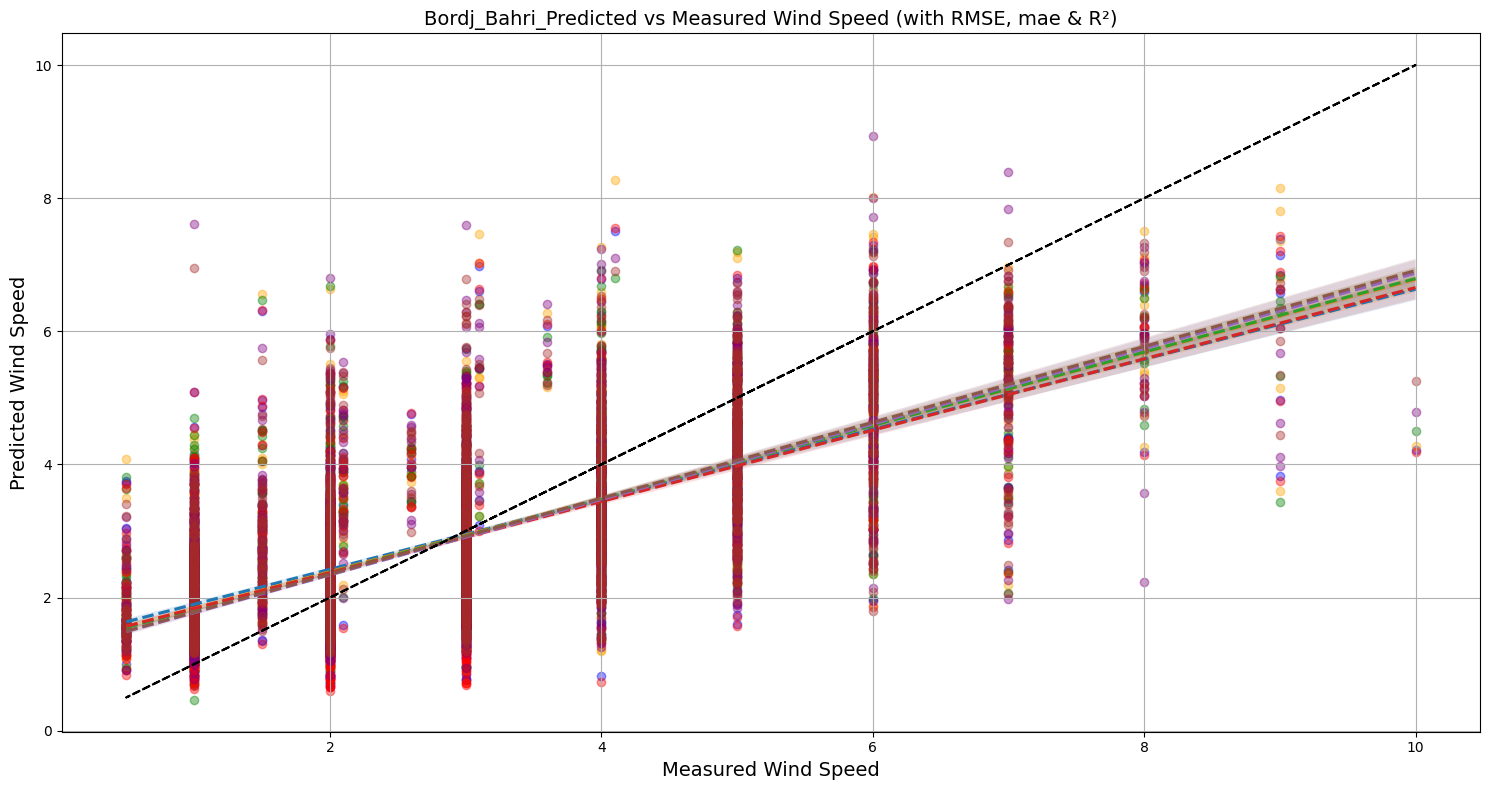

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

# Compute metrics for each model
metrics = {
    'Linear Regression': {
        'pred': ylin,
    },
    'Poly deg2': {
        'pred': y_predpoly2,
    },
    'Poly deg3': {
        'pred': y_predpoly3,
    }, 
    'RANSAC': {
        'pred': Y_predRANSAC,
    },
    'XGBoost': {
        'pred': y_predXGB,
    },
    'Random Forest': {
        'pred': ypredbest,
    },
}

# Compute MSE and R² for each model
for model, data in metrics.items():
    pred = data['pred']
    data['r2'] = r2_score(y_test, pred)
    data['rmse'] = root_mean_squared_error(y_test, pred)
    data['mae'] = mean_absolute_error(y_test, pred)
# Create plot
plt.figure(figsize=(15, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Plot scatter for each model and annotate metrics
for (model, data), color in zip(metrics.items(), colors):
    plt.scatter(y_test, data['pred'], alpha=0.4, label=f"{model}\nRMSE={data['rmse']:.3f}, R²={data['r2']:.3f},mae={data['mae']:.3f}", color=color)
    sns.regplot(x=y_test, y=data['pred'], label=f"{model}", scatter=False, line_kws={"linestyle":"--"})

# Plot ideal prediction line (perfect predictions)
plt.plot(y_test, y_test, color='black', linestyle='--', label='Perfect Prediction (y = x)')

# Customize plot
plt.xlabel('Measured Wind Speed',fontsize=14)
plt.ylabel('Predicted Wind Speed',fontsize=14)
plt.title('Bordj_Bahri_Predicted vs Measured Wind Speed (with RMSE, mae & R²)',fontsize=14)
#plt.legend(loc='upper left', ncol=3, fontsize=10)
#plt.legend(loc='lower right', ncol=4, fontsize=10, bbox_to_anchor=(1.05,1))
plt.grid(True)
plt.tight_layout()

plt.show()